In [1]:
import torch
from torch import optim
from torch.autograd import Variable
import numpy as np
import os
import math
from torch import nn
import torchvision

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import matplotlib.pyplot as plt  
import itertools
import random
import tqdm
from tqdm import tnrange
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
torch.cuda.is_available()

True

## DataLoader

In [3]:
### handle the dataset
class TorchDataset(Dataset):
    def __init__(self, trs_file, label_file, trace_num, trace_offset, trace_length):
        self.trs_file = trs_file
        self.label_file = label_file
        self.trace_num = trace_num
        self.trace_offset = trace_offset
        self.trace_length = trace_length
        self.ToTensor = transforms.ToTensor()
    def __getitem__(self, i):
        index = i % self.trace_num
        trace = self.trs_file[index,:]
        label = self.label_file[index]
        trace = trace[self.trace_offset:self.trace_offset+self.trace_length]
        trace = np.reshape(trace,(1,-1))
        trace = self.ToTensor(trace)
        trace = np.reshape(trace, (1,-1))
        label = torch.tensor(label, dtype=torch.long) 
        return trace.float(), label
    def __len__(self):
        return self.trace_num
    
### data loader for training
def load_training(batch_size, kwargs):
    data = TorchDataset(**kwargs)
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=1, pin_memory=True)
    return train_loader

### data loader for testing
def load_testing(batch_size, kwargs):
    data = TorchDataset(**kwargs)
    test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=1, pin_memory=True)
    return test_loader

## Arrays and Functions

In [4]:
Sbox = [99, 124, 119, 123, 242, 107, 111, 197, 48, 1, 103, 43, 254, 215, 171, 118, 202, 130, 201, 125, 250, 89, 71,
        240, 173, 212, 162, 175, 156, 164, 114, 192, 183, 253, 147, 38, 54, 63, 247, 204, 52, 165, 229, 241, 113, 216,
        49, 21, 4, 199, 35, 195, 24, 150, 5, 154, 7, 18, 128, 226, 235, 39, 178, 117, 9, 131, 44, 26, 27, 110, 90, 160,
        82, 59, 214, 179, 41, 227, 47, 132, 83, 209, 0, 237, 32, 252, 177, 91, 106, 203, 190, 57, 74, 76, 88, 207, 208,
        239, 170, 251, 67, 77, 51, 133, 69, 249, 2, 127, 80, 60, 159, 168, 81, 163, 64, 143, 146, 157, 56, 245, 188,
        182, 218, 33, 16, 255, 243, 210, 205, 12, 19, 236, 95, 151, 68, 23, 196, 167, 126, 61, 100, 93, 25, 115, 96,
        129, 79, 220, 34, 42, 144, 136, 70, 238, 184, 20, 222, 94, 11, 219, 224, 50, 58, 10, 73, 6, 36, 92, 194, 211,
        172, 98, 145, 149, 228, 121, 231, 200, 55, 109, 141, 213, 78, 169, 108, 86, 244, 234, 101, 122, 174, 8, 186,
        120, 37, 46, 28, 166, 180, 198, 232, 221, 116, 31, 75, 189, 139, 138, 112, 62, 181, 102, 72, 3, 246, 14, 97,
        53, 87, 185, 134, 193, 29, 158, 225, 248, 152, 17, 105, 217, 142, 148, 155, 30, 135, 233, 206, 85, 40, 223, 140,
        161, 137, 13, 191, 230, 66, 104, 65, 153, 45, 15, 176, 84, 187, 22]

HW_byte = [0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 1, 2, 2,
            3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 1, 2, 2, 3, 2, 3,
            3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 2, 3, 3, 4, 3, 4, 4, 5, 3,
            4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4,
            3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5,
            6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4,
            4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 4, 5, 5, 6, 5,
            6, 6, 7, 5, 6, 6, 7, 6, 7, 7, 8]



### test/attack
def test(model, device_id, disp_GE=True, model_flag='pretrained'):
    """
    - model : the current model 
    - device_id : id of the tested device
    - disp_GE : whether to attack/calculate guessing entropy (GE)
    - model_flag : a string for naming GE result
    """
    # enter evaluation mode
    model.eval()
    test_loss = 0
    # the number of correct prediction
    correct = 0
    epoch = 0
    clf_criterion = nn.CrossEntropyLoss()
    if device_id == source_device_id: # attack on the source domain
        test_num = source_test_num
        test_loader = source_test_loader
        real_key = real_key_01
    else: # attack on the target domain
        test_num = target_test_num
        test_loader = target_test_loader
        real_key = real_key_02
      # Initialize the prediction and label lists(tensors)
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
    test_preds_all = torch.zeros((test_num, class_num), dtype=torch.float, device='cpu')
    for data, label in test_loader:
        if cuda:
            data, label = data.cuda(), label.cuda()
        data, label = Variable(data), Variable(label)
        test_preds = model(data)
        # sum up batcsh loss
        test_loss += clf_criterion(test_preds, label) 
        # get the index of the max probability
        pred = test_preds.data.max(1)[1]
        # get the softmax results for attack/showing guessing entropy
        softmax = nn.Softmax(dim=1)
        test_preds_all[epoch*batch_size:(epoch+1)*batch_size, :] =softmax(test_preds)
        # get the predictions (predlist) and real labels (lbllist) for showing confusion matrix
        predlist=torch.cat([predlist,pred.view(-1).cpu()])
        lbllist=torch.cat([lbllist,label.view(-1).cpu()])
        # get the number of correct prediction
        correct += pred.eq(label.data.view_as(pred)).cpu().sum()
        epoch += 1
    test_loss /= len(test_loader)
    print('Target test loss: {:.4f}, Target test accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss.data, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    # get the confusion matrix
    confusion_mat = confusion_matrix(lbllist.numpy(), predlist.numpy())
    # show the confusion matrix
    plot_sonfusion_matrix(confusion_mat, classes = range(class_num))
    # show the guessing entropy and success rate
    if disp_GE:
        plot_guessing_entropy(test_preds_all.numpy(), real_key, device_id, model_flag)

### show the guessing entropy and success rate
def plot_guessing_entropy(preds, real_key, device_id, model_flag):
    """
    - preds : the probability for each class (n*256 for a byte, n*9 for Hamming weight)
    - real_key : the key of the target device
    - device_id : id of the target device
    - model_flag : a string for naming GE result
    """
    # GE/SR is averaged over 100 attacks 
    num_averaged = 1
    # max trace num for attack
    trace_num_max = 10000
    guessing_entropy = np.zeros((num_averaged, trace_num_max))
    success_flag = np.zeros((num_averaged, trace_num_max))
    plaintext = plaintexts_source

    # attack multiples times for average
    for time in tnrange(num_averaged):
        # select the attack traces randomly
        random_index = list(range(plaintext.shape[0]))
        random.shuffle(random_index)
        random_index = random_index[0:trace_num_max]
        # initialize score matrix
        score_mat = np.zeros((trace_num_max, 256))
        for key_guess in range(0, 256):
            for i in range(0, trace_num_max):
                initialState = plaintext[random_index[i]] ^ key_guess
                sout = Sbox[int(initialState)]
                if labeling_method == 'identity':
                    label = sout
                elif labeling_method == 'hw':
                    label = HW_byte[sout]
                score_mat[i, key_guess] = preds[random_index[i], label]
        score_mat = np.log(score_mat + 1e-40)
        for i in range(0, trace_num_max):
            log_likelihood = np.sum(score_mat[0:i+1,:], axis=0)
            ranked = np.argsort(log_likelihood)[::-1]
            guessing_entropy[time,i] =  list(ranked).index(real_key)
            if list(ranked).index(real_key) == 0:
                    success_flag[time, i] = 1
    guessing_entropy = np.mean(guessing_entropy,axis=0)
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    p1, = plt.plot(guessing_entropy[0:trace_num_max],color='red')
    plt.xlabel('Number of trace')
    plt.ylabel('Guessing entropy')
    #np.save('./results/entropy_'+ labeling_method + '_{}_to_{}_'.format(source_device_id, device_id) + model_flag, guessing_entropy)
    plt.subplot(1, 2, 2)       
    success_flag = np.sum(success_flag, axis=0)
    success_rate = success_flag/num_averaged 
    p2, = plt.plot(success_rate[0:trace_num_max], color='red')
    plt.xlabel('Number of trace')
    plt.ylabel('Success rate')
    plt.show()
    for i in range(len(guessing_entropy)):
        if guessing_entropy[i]<.6:
            print("KRC:",i)
            break
    if i>=len(guessing_entropy):
        print("BOT:")
    
    
    #np.save('./results/success_rate_' + labeling_method + '_{}_to_{}_'.format(source_device_id, device_id) + model_flag, success_rate)

### show the confusion matrix 
def plot_sonfusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    thresh = cm.max()/2.0
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j], horizontalalignment='center',color='white' if cm[i,j] > thresh else 'black')   
    plt.ylim((len(classes)-0.5, -0.5))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')
    plt.show()

## Setups

In [14]:
source_device_id = 1
real_key_01 = 0xd8 # key of the source domain
lambda_ = 0.1 # Penalty coefficient
labeling_method = 'hw' # labeling of trace
preprocess = 'horizontal_standardization' # preprocess method
batch_size = 250
lr = 0.001 # learning rate
log_interval = 20 # epoch interval to log training information
source_test_num = 10000
trace_offset = 0
trace_length = 1500
source_file_path = './Data/ourdata/xmega/L11/'
checkpoint = torch.load('./models/xmega/T1/last_valid_loss_finetuned_deviceL11L11.pth'.format(source_device_id))
no_cuda =False
cuda = not no_cuda and torch.cuda.is_available()
seed = 8
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)
if labeling_method == 'identity':
    class_num = 256
elif labeling_method == 'hw':
    class_num = 9
    
# to load traces and labels
X_attack_source = np.load(source_file_path + 'X_attack.npy')
Y_attack_source = np.load(source_file_path + 'Y_attack.npy')
# to load plaintexts
plaintexts_source = np.load(source_file_path + 'plaintexts_attack.npy')

# preprocess of traces
if preprocess == 'horizontal_standardization':
    mn = np.repeat(np.mean(X_attack_source, axis=1, keepdims=True), X_attack_source.shape[1], axis=1)
    std = np.repeat(np.std(X_attack_source, axis=1, keepdims=True), X_attack_source.shape[1], axis=1)
    X_attack_source = (X_attack_source - mn)/std

elif preprocess == 'horizontal_scaling':
    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X_attack_source.T)
    X_attack_source = scaler.transform(X_attack_source.T).T


kwargs_source_test = {
        'trs_file': X_attack_source,
        'label_file': Y_attack_source,
        'trace_num':source_test_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}

source_test_loader = load_testing(batch_size, kwargs_source_test)
print('Load data complete!')

Load data complete!


## Models

In [15]:
### the pre-trained model
class Net(nn.Module):
    def __init__(self, num_classes=class_num):
        super(Net, self).__init__()
        # the encoder part
        self.features = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=1),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(16, 32, kernel_size=50),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=50, stride=50),
            nn.Conv1d(32, 64, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        # the fully-connected layer 1
        self.classifier_1 = nn.Sequential(
            nn.Linear(384, 20),
            nn.ReLU(inplace=True),
        )
        # the output layer
        self.final_classifier = nn.Sequential(
            nn.Linear(20, num_classes)
        )

    # how the network runs
    def forward(self, input):
        x = self.features(input)
        x = x.view(x.size(0), -1)
        x = self.classifier_1(x)
        output = self.final_classifier(x)
        return output

### the fine-tuning model
class CDP_Net(nn.Module):
    def __init__(self, num_classes=class_num):
        super(CDP_Net, self).__init__()
        # the encoder part
        self.features = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=1),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(16, 32, kernel_size=50),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=50, stride=50),
            nn.Conv1d(32, 64, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        # the fully-connected layer 1
        self.classifier_1 = nn.Sequential(
            nn.Linear(384, 20),
            nn.ReLU(inplace=True),
        )
        # the output layer
        self.final_classifier = nn.Sequential(
            nn.Linear(20, num_classes)
        )
        
    # how the network runs
    def forward(self, source, target):
        mmd_loss = 0
        #source data flow
        source = self.features(source)
        source_0 = source.view(source.size(0), -1)
        source_1 = self.classifier_1(source_0)
        
        #target data flow
        target = self.features(target)
        target = target.view(target.size(0), -1)
        mmd_loss += mmd_rbf(source_0, target)
        target = self.classifier_1(target)
        mmd_loss += mmd_rbf(source_1, target)
        
        result = self.final_classifier(source_1)
        return result, mmd_loss

## Performance of the pre-trained model

Construct model complete
Result on source device:
Target test loss: 3.7064, Target test accuracy: 2401/10000 (24.01%)



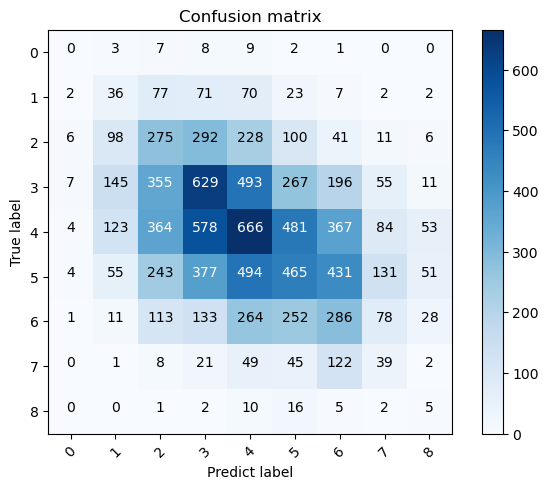

/tmp/ipykernel_2661890/3925007971.py:98: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for time in tnrange(num_averaged):


  0%|          | 0/1 [00:00<?, ?it/s]

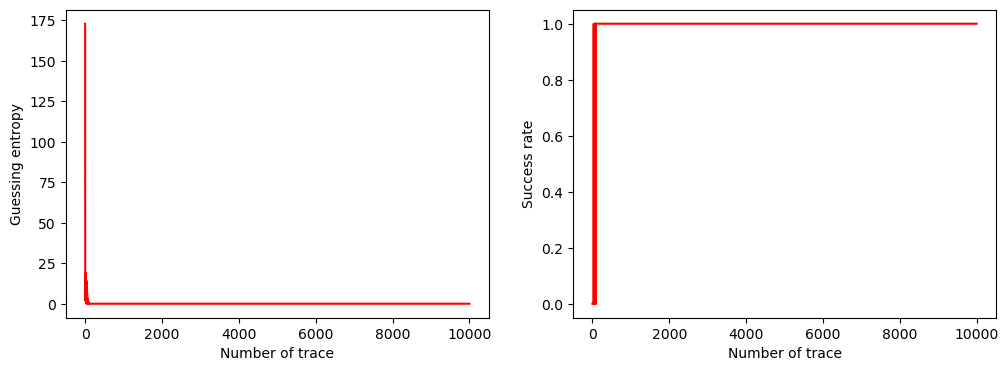

KRC: 34


In [16]:
# create a network
model = Net(num_classes=class_num)
print('Construct model complete')
if cuda:
    model.cuda()
    
# load the pre-trained network
pretrained_dict = checkpoint['model_state_dict']
model.load_state_dict(pretrained_dict)

# evaluate the pre-trained model on source and target domain
with torch.no_grad():
    
    print('Result on source device:')
    test(model, source_device_id, model_flag='pretrained_source')
    
#     print('Result on target device:')
#     test(model, target_device_id, model_flag='pretrained_target')